# Global fit to all three K2 campaign lightcurves

In [ ]:
# %load /Users/obsidian/Desktop/defaults.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from celerite.modeling import Model

# Define the model
class MeanModel(Model):
    parameter_names = ("alpha", "ell", "log_sigma2")

    def get_value(self, t):
        return self.alpha * np.exp(-0.5*(t-self.ell)**2 * np.exp(-self.log_sigma2))

    # This method is optional but it can be used to compute the gradient of the
    # cost function below.
    def compute_gradient(self, t):
        e = 0.5*(t-self.ell)**2 * np.exp(-self.log_sigma2)
        dalpha = np.exp(-e)
        dell = self.alpha * dalpha * (t-self.ell) * np.exp(-self.log_sigma2)
        dlog_s2 = self.alpha * dalpha * e
        return np.array([dalpha, dell, dlog_s2])

mean_model = MeanModel(alpha=-1.0, ell=0.1, log_sigma2=np.log(0.4))
true_params = mean_model.get_parameter_vector()

# Simuate the data
np.random.seed(42)
x = np.sort(np.random.uniform(-5, 5, 50))
yerr = np.random.uniform(0.05, 0.1, len(x))
K = 0.1*np.exp(-0.5*(x[:, None] - x[None, :])**2/10.5)
K[np.diag_indices(len(x))] += yerr**2
y = np.random.multivariate_normal(mean_model.get_value(x), K)

# Plot the data
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
plt.xlim(-5, 5)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title("simulated data");

In [ ]:
from scipy.optimize import minimize

import celerite
from celerite import terms

# Set up the GP model
kernel = terms.RealTerm(log_a=np.log(np.var(y)), log_c=-np.log(10.0))
gp = celerite.GP(kernel, mean=mean_model, fit_mean=True)
gp.compute(x, yerr)
print("Initial log-likelihood: {0}".format(gp.log_likelihood(y)))

# Define a cost function
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

# Fit for the maximum likelihood parameters
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(soln.x)
print("Final log-likelihood: {0}".format(-soln.fun))

# Make the maximum likelihood prediction
t = np.linspace(-5, 5, 500)
mu, var = gp.predict(y, t, return_var=True)
std = np.sqrt(var)

# Plot the data
color = "#ff7f0e"
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(t, mu, color=color)
plt.fill_between(t, mu+std, mu-std, color=color, alpha=0.3, edgecolor="none")
plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
plt.xlim(-5, 5)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title("maximum likelihood prediction");

In [ ]:
def log_probability(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return gp.log_likelihood(y) + lp

In [ ]:
import emcee

initial = np.array(soln.x)
ndim, nwalkers = len(initial), 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

print("Running burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 500)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 2000);

## SHO model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

t = np.sort(np.append(
    np.random.uniform(0, 3.8, 57),
    np.random.uniform(5.5, 10, 68),
))  # The input coordinates must be sorted
yerr = np.random.uniform(0.08, 0.22, len(t))
y = 0.2 * (t-5) + np.sin(3*t + 0.1*(t-5)**2) + yerr * np.random.randn(len(t))

true_t = np.linspace(0, 10, 5000)
true_y = 0.2 * (true_t-5) + np.sin(3*true_t + 0.1*(true_t-5)**2)

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5);

In [ ]:
import celerite
from celerite import terms

# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# A periodic component
Q = 1.0
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)


In [ ]:
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

In [ ]:
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
print("parameter_names:\n{0}\n".format(gp.get_parameter_names()))
print("parameter_vector:\n{0}\n".format(gp.get_parameter_vector()))
print("parameter_bounds:\n{0}\n".format(gp.get_parameter_bounds()))


In [ ]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

In [ ]:
gp.get_parameter_dict()

In [ ]:
x = np.linspace(0, 10, 5000)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

In [ ]:
color = "#ff7f0e"
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5);

In [ ]:
omega = np.exp(np.linspace(np.log(0.1), np.log(20), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(omega, psd, color=color)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--", color=color)

plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");

# subsub K2 design matrix

In [1]:
# %load /Users/obsidian/Desktop/defaults.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
! ls ../data/K2/

S1063_K2_C05_lightkurve_SFF.csv S1063_K2_C18_lightkurve_SFF.csv
S1063_K2_C16_lightkurve_SFF.csv


In [3]:
dfC05 = pd.read_csv('../data/K2/S1063_K2_C05_lightkurve_SFF.csv')
dfC16 = pd.read_csv('../data/K2/S1063_K2_C16_lightkurve_SFF.csv')
dfC18 = pd.read_csv('../data/K2/S1063_K2_C18_lightkurve_SFF.csv')

In [4]:
df = pd.concat([dfC05, dfC16, dfC18], ignore_index=True)
df['flux'] = df.flux / np.percentile(df.flux, 98)

#df = pd.concat([dfC16], ignore_index=True)
#df['flux'] = df.flux / np.percentile(df.flux, 98)

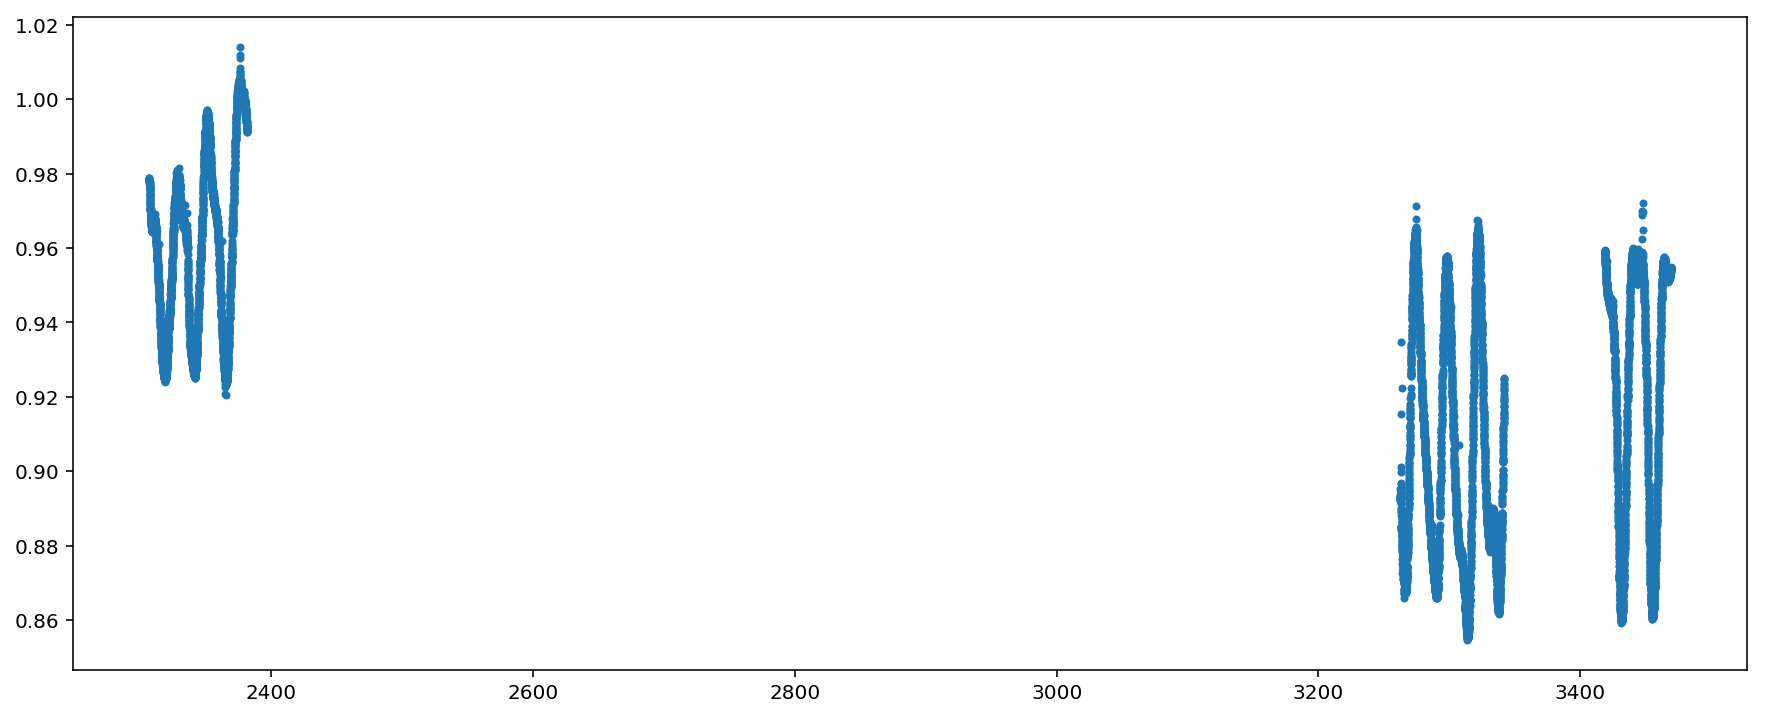

In [5]:
plt.figure(figsize=(15, 6))
plt.plot(df.time, df.flux, '.')

In [6]:
(dfC05.time.iloc[-1]-dfC05.time.iloc[0] + 
 dfC16.time.iloc[-1]-dfC16.time.iloc[0] + 
 dfC18.time.iloc[-1]-dfC18.time.iloc[0] )

205.21106635380238

In [7]:
dfC18.time.iloc[-1]-dfC05.time.iloc[0]


1162.7700801524038

In [8]:
#mask = (df.time < 3308) & (df.time > 3292) # C16
#mask = (df.time < 3445) & (df.time > 3435) # C18
#mask = (df.time < 2340) & (df.time > 2325) # C05

In [9]:
df_subset = df#[~mask]

In [10]:
t = df_subset.time.values
y = df_subset.flux
yerr = 0.001 * np.ones(len(t))

<ErrorbarContainer object of 3 artists>

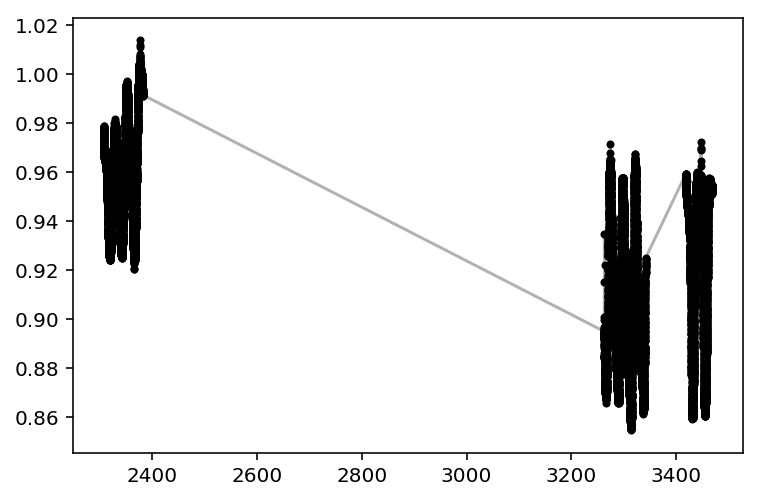

In [11]:
plt.plot(df.time, df.flux, "k", lw=1.5, alpha=0.3)
plt.plot(t, y,".k")
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.1)
#plt.ylim(0.99, 1.0)
#plt.xlim(3272, 3273)

<ErrorbarContainer object of 3 artists>

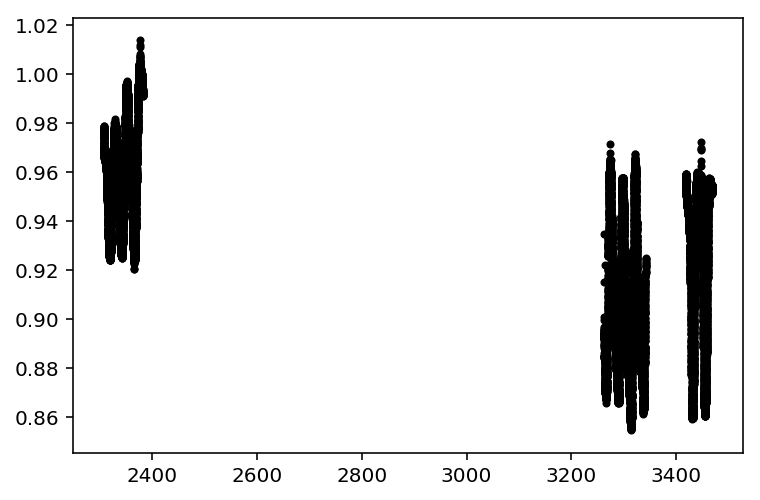

In [12]:
plt.plot(t, y,".k")
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.1)
#plt.ylim(0.985, 1.0)
#plt.xlim(3272, 3273)

In [13]:
2.0 * np.pi / 23.5

0.26736958753955686

Try design matrix approach

In [14]:
P_fit = 23.67
P_fit2 = 7.48

In [15]:
x = t
x_dense = np.arange(df.time.iloc[0], df.time.iloc[-1], 1.0/24/2.0)

In [16]:
sin_vector = np.sin(2.0*np.pi*x/P_fit)
cos_vector = np.cos(2.0*np.pi*x/P_fit)
sin_vector2 = np.sin(2.0*np.pi*x/(P_fit2))
cos_vector2 = np.cos(2.0*np.pi*x/(P_fit2))

A = np.concatenate((np.expand_dims(sin_vector, 1),
                    np.expand_dims(cos_vector, 1),
                    np.expand_dims(sin_vector2, 1),
                    np.expand_dims(cos_vector2, 1),
                    np.vander(x, 3)), axis=1)

ATA = np.dot(A.T, A / yerr[:, None]**2)
sigma_w = np.linalg.inv(ATA)
mean_w = np.linalg.solve(ATA, np.dot(A.T, y/yerr**2))

yfit = np.matmul(mean_w, A.T)


A_dense = np.concatenate((np.expand_dims(np.sin(2.0*np.pi*x_dense/P_fit), 1),
                          np.expand_dims(np.cos(2.0*np.pi*x_dense/P_fit), 1),
                          np.expand_dims(np.cos(2.0*np.pi*x_dense/(P_fit2)), 1),
                          np.expand_dims(np.cos(2.0*np.pi*x_dense/(P_fit2)), 1),
                          np.vander(x_dense, 3)), axis=1)

yfit_dense = np.matmul(mean_w, A_dense.T)

In [17]:
df_fit = pd.DataFrame({'time':x_dense, 'flux':yfit_dense})

In [18]:
def compute_ydense(P1, P2):
    sin_vector = np.sin(2.0*np.pi*x/P1)
    cos_vector = np.cos(2.0*np.pi*x/P1)
    sin_vector2 = np.sin(2.0*np.pi*x/(P2))
    cos_vector2 = np.cos(2.0*np.pi*x/(P2))

    A = np.concatenate((np.expand_dims(sin_vector, 1),
                        np.expand_dims(cos_vector, 1),
                        np.expand_dims(sin_vector2, 1),
                        np.expand_dims(cos_vector2, 1),
                        np.vander(x, 3)), axis=1)

    ATA = np.dot(A.T, A / yerr[:, None]**2)
    sigma_w = np.linalg.inv(ATA)
    mean_w = np.linalg.solve(ATA, np.dot(A.T, y/yerr**2))

    yfit = np.matmul(mean_w, A.T)

    A_dense = np.concatenate((np.expand_dims(np.sin(2.0*np.pi*x_dense/P1), 1),
                              np.expand_dims(np.cos(2.0*np.pi*x_dense/P1), 1),
                              np.expand_dims(np.cos(2.0*np.pi*x_dense/(P2)), 1),
                              np.expand_dims(np.cos(2.0*np.pi*x_dense/(P2)), 1),
                              np.vander(x_dense, 3)), axis=1)

    yfit_dense = np.matmul(mean_w, A_dense.T)
    return yfit_dense

In [19]:
def compute_chisq(P1, P2):
    sin_vector = np.sin(2.0*np.pi*x/P1)
    cos_vector = np.cos(2.0*np.pi*x/P1)
    sin_vector2 = np.sin(2.0*np.pi*x/(P2))
    cos_vector2 = np.cos(2.0*np.pi*x/(P2))

    A = np.concatenate((np.expand_dims(sin_vector, 1),
                        np.expand_dims(cos_vector, 1),
                        np.expand_dims(sin_vector2, 1),
                        np.expand_dims(cos_vector2, 1),
                        np.vander(x, 3)), axis=1)

    ATA = np.dot(A.T, A / yerr[:, None]**2)
    sigma_w = np.linalg.inv(ATA)
    mean_w = np.linalg.solve(ATA, np.dot(A.T, y/yerr**2))

    yfit = np.matmul(mean_w, A.T)
    resid_sq = (yfit-y)**2
    return np.sum(resid_sq)

In [20]:
import yaml

from bokeh.layouts import column, widgetbox
from bokeh.models import ColumnDataSource, Slider
from bokeh.plotting import figure
from bokeh.themes import Theme
from bokeh.io import show, output_notebook

from bokeh.sampledata.sea_surface_temperature import sea_surface_temperature

output_notebook()

Loading BokehJS ...

In [21]:
slider = Slider(start=0, end=30, value=0, step=1, title="Smoothing by N Days")

In [22]:
source2 = ColumnDataSource(data=df_fit)

In [23]:
def modify_doc(doc):
    source = ColumnDataSource(data=df)
    source2 = ColumnDataSource(data=df_fit)

    plot = figure()
    plot.line('time', 'flux', source=source)
    plot.line('time', 'flux', source=source2, color='red')
    

    def callback(attr, old, new):
        term1 = np.sin(2.0*np.pi*(x_dense - slider3.value)/slider1.value)
        #term2 = np.cos(2.0*np.pi*x_dense/slider1.value)
        #net = slider2.value*term1 + slider3.value*term2 + slider4.value
        net1 = slider2.value*term1 + slider4.value
        
        term2 = np.sin(2.0*np.pi*(x_dense - slider7.value)/slider5.value)
        net2 = slider6.value * term2 
        
        source2.data['flux'] = net1 + net2
        
    def callback2(attr, old, new):
        
        ydense = compute_ydense(slider1.value, slider5.value)
        source2.data['flux'] = ydense
    
    slider1 = Slider(start=22, end=25, value=23.32, step=0.001, title="P1", width=600)
    #slider2 = Slider(start=0, end=0.2, value=0.05, step=0.001, title="A")
    #slider3 = Slider(start=0, end=24, value=1.85, step=0.05, title="Phase")
    #slider4 = Slider(start=0.9, end=1, value=0.95, step=0.001, title="C")
    
    slider5 = Slider(start=11.0, end=14.0, value=12.5, step=0.001, title="P2", width=600)
    #slider6 = Slider(start=0, end=0.2, value=0.01, step=0.001, title="B")
    #slider7 = Slider(start=0, end=24, value=1.85, step=0.05, title="Phase2")
    
    
    slider1.on_change('value', callback2)
    #slider2.on_change('value', callback)
    #slider3.on_change('value', callback)
    #slider4.on_change('value', callback)
    slider5.on_change('value', callback2)
    #slider6.on_change('value', callback)
    #slider7.on_change('value', callback)

    #doc.add_root(column(widgetbox([slider1, slider2, slider3, slider4,slider5, slider6, slider7]), plot))
    doc.add_root(column(widgetbox([slider1, slider5]), plot))

In [24]:
slid = show(modify_doc)

ERROR:bokeh.server.views.ws:Refusing websocket connection from Origin 'http://localhost:8889';                       use --allow-websocket-origin=localhost:8889 or set BOKEH_ALLOW_WS_ORIGIN=localhost:8889 to permit this; currently we allow origins {'localhost:8888'}


In [40]:
P1_grid = np.arange(23.7, 25.0, 0.001)
P2_grid = np.arange(11.8, 12.1, 0.001)

In [46]:
chisq_grid = np.zeros((P1_grid.shape[0], P2_grid.shape[0]))

In [53]:
from tqdm import tqdm

In [55]:
for i, P1 in tqdm(enumerate(P1_grid)):
    for j, P2 in enumerate(P2_grid):
        chisq_grid[i, j] = compute_chisq(P1, P2)

1301it [07:32,  3.02it/s]


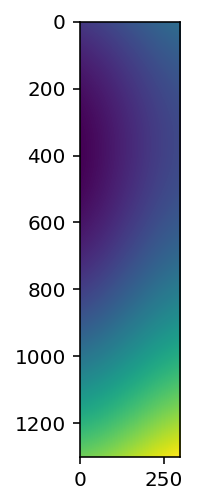

In [57]:
plt.figure(figsize=(10, 4))
plt.imshow(chisq_grid)

In [63]:
np.unravel_index(np.argmin(chisq_grid), chisq_grid.shape)

(386, 0)

In [65]:
P1_grid[386]

24.08600000000047

In [66]:
P2_grid[0]

11.8

Text(0, 0.5, 'y')

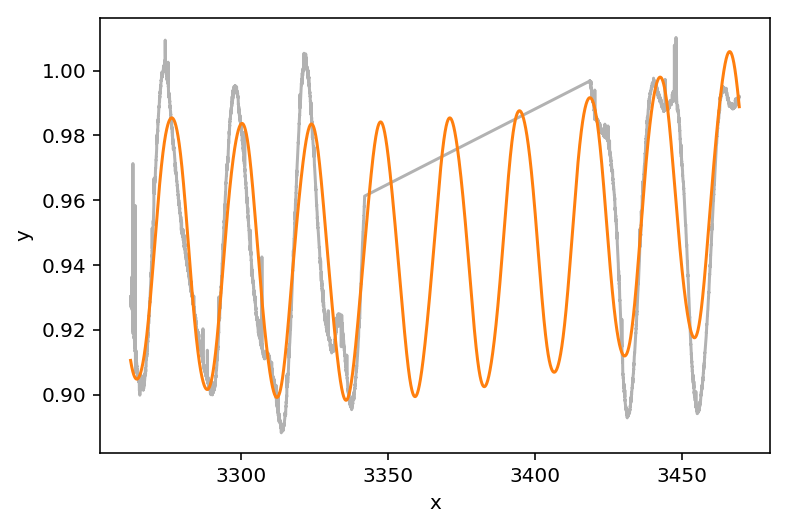

In [16]:
color = "#ff7f0e"
plt.plot(df.time, df.flux, "k", lw=1.5, alpha=0.3)
#plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_dense, yfit_dense, color=color)

plt.xlabel("x")
plt.ylabel("y")

(3272, 3273)

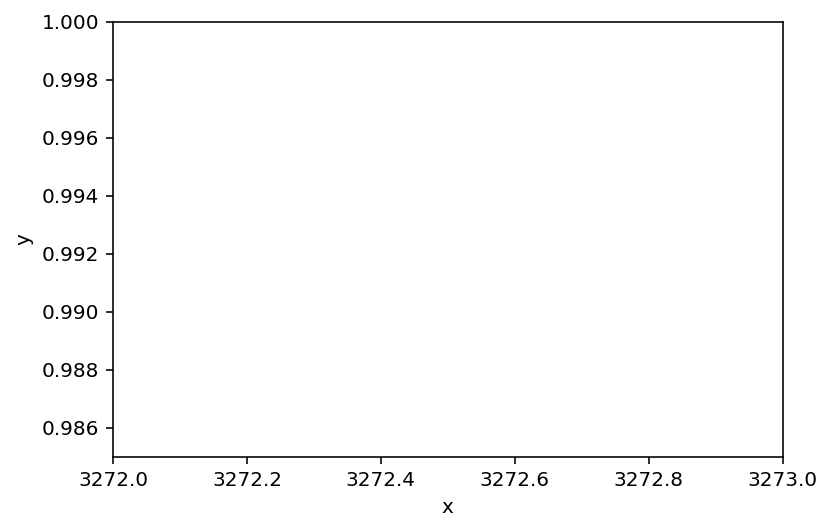

In [18]:
color = "#ff7f0e"
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(0.985, 1.0)
plt.xlim(3272, 3273)

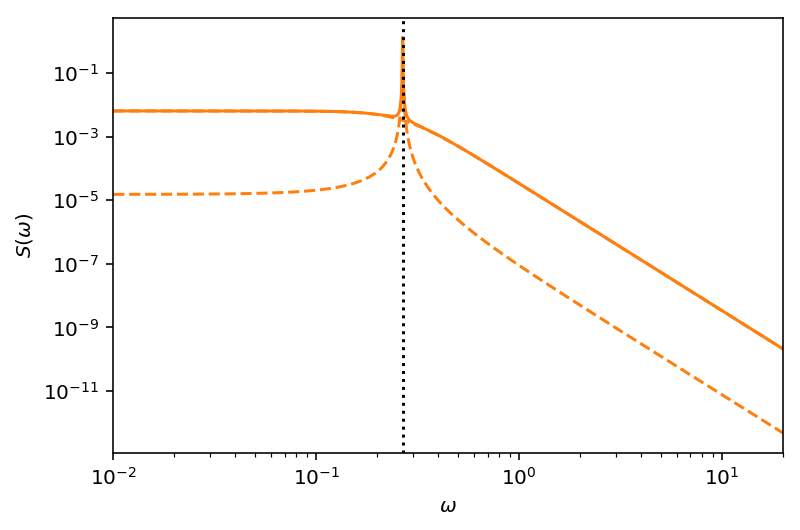

In [19]:
omega = np.exp(np.linspace(np.log(0.01), np.log(20), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(omega, psd, color=color)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--", color=color)

    
plt.axvline(2.0*np.pi/23.5, color='k', linestyle='dotted')

plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");

In [23]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

      fun: -30390.200967322966
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([  0.05529728, -19.56577762,   0.41400199,   0.21245796,
         0.99244062])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 162
      nit: 15
   status: 0
  success: True
        x: array([ -5.14267274,  -1.20779313, -11.06866574,   5.69239589,
        -1.34122134])


In [24]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_S0', -5.142672743279033),
             ('kernel:terms[0]:log_omega0', -1.2077931308481822),
             ('kernel:terms[1]:log_S0', -11.068665741867752),
             ('kernel:terms[1]:log_Q', 5.692395889506324),
             ('kernel:terms[1]:log_omega0', -1.3412213355815639)])

In [25]:
x = np.arange(df.time.iloc[0], df.time.iloc[-1], 1.0/24/2.0)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

Text(0, 0.5, 'y')

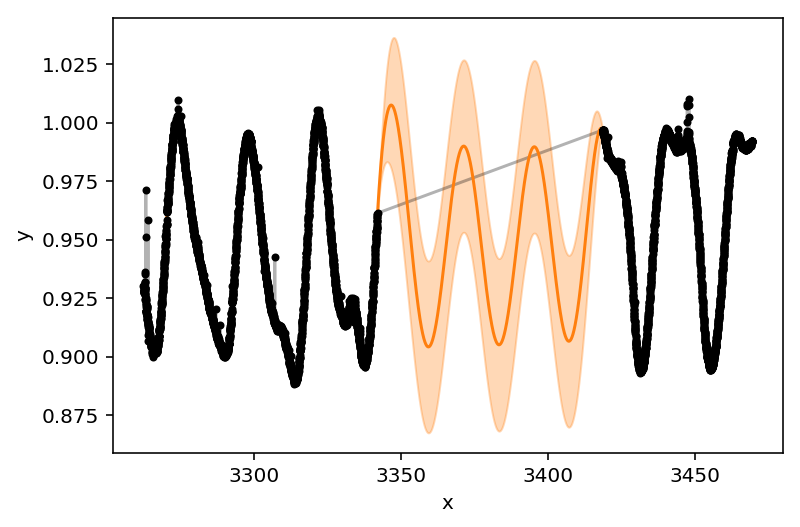

In [26]:
color = "#ff7f0e"
plt.plot(df.time, df.flux, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")

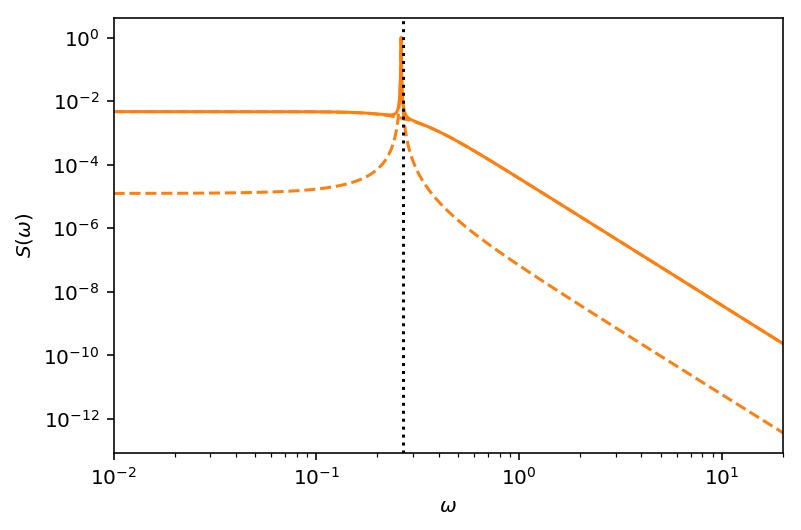

In [27]:
omega = np.exp(np.linspace(np.log(0.01), np.log(20), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(omega, psd, color=color)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--", color=color)

    
plt.axvline(2.0*np.pi/23.5, color='k', linestyle='dotted')

plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");